In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
from PIL import Image
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from matplotlib.pyplot import imshow

from yolo3.model import *
from yolo3.utils import *
from train_pairs import *
from yolo import *
import tensorflow as tf

gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
    
annotation_path = 'CrowdHuman_train_sp.txt'
annotation_path2 = 'CrowdHuman_train.txt'
#annotation_path = 'train_coco2014.txt'
log_dir = 'logs/pairs_/'
classes_path = 'model_data/CrowdHuman_classes.txt'
#classes_path = 'model_data/coco_classes.txt'
anchors_path = 'model_data/yolo_anchors_CH.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)


val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
#np.random.seed(10101)
#np.random.shuffle(lines)
#np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val
input_shape = (416,416) # multiple of 32, hw
print('1')

Using TensorFlow backend.


1


In [2]:
weights_path='model_data/pairs_ep258-loss188.367-val_loss193.041.h5' # make sure you know what you freeze


num_anchors = len(anchors)
image_input = Input(shape=(None, None, 3))
model_ops= yolo_pairs_body(image_input, num_anchors//3, num_classes)
model_ops.load_weights(weights_path, by_name=True, skip_mismatch=True)
print('2')

2


In [3]:
model = create_pairs_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path=weights_path) # make sure you know what you freeze

model.compile(optimizer=Adam(lr=1e-3), loss={
            # use custom yolo_loss Lambda layer.
            'yolo_loss': lambda y_true, y_pred: y_pred})
print('3')

Create YOLOv3 model with 9 anchors and 3 classes.
Load weights model_data/pairs_ep258-loss188.367-val_loss193.041.h5.
Freeze the first 249 layers of total 252 layers.
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`

3


In [4]:
for a in data_generator_wrapper_pairs(lines[:num_train], 1, input_shape, anchors, num_classes):
    b=a
    
    break


#model_ops=Model(model_ops.input,model_ops.output)
#model_ops.input=b[0]
yolo_outputs=model.predict(b[0],batch_size=32)
ticks = time.time()
dataNew='./yolo_gt_bboxes'+str(ticks)+'.mat'
#sess=tf.Session()
scio.savemat(dataNew, {'image':np.float32(a[0][0][0]),'bboxse0':np.float32(a[0][1]),'bboxes2':np.float32(a[0][2]),'bboxes3':np.float32(a[0][3])})


print('4')

4


(416, 416, 3)
(1, 13, 13, 3, 15)
0.8726098277351474
4.25


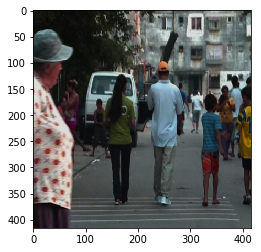

In [5]:

print(np.shape(a[0][0][0]))
print(np.shape(a[0][1]))
imshow(a[0][0][0])
print(np.max(a[0][0][0]))
rsgt=K.reshape(a[0][1],[-1,13,13,3,3,5])




object_mask = rsgt[..., 4:5]
# Darknet raw box to calculate loss.
raw_true_xy = rsgt[..., :2]#*grid_shapes[l][::-1] #- grid_rs
raw_true_wh = rsgt[..., 2:4]
raw_true_wh = K.switch(object_mask, raw_true_wh, K.zeros_like(raw_true_wh)) # avoid log(0)=-inf

sess=tf.Session()
rsgt=rsgt.eval(session=sess)
raw_true_xy=raw_true_xy.eval(session=sess)
raw_true_wh=raw_true_wh.eval(session=sess)
object_mask=object_mask.eval(session=sess)
ticks = time.time()
dataNew='./yolo_rsgt'+str(ticks)+'.mat'
scio.savemat(dataNew, {'rsgt':np.float32(rsgt),'raw_true_xy':np.float32(raw_true_xy),'raw_true_wh':np.float32(raw_true_wh),'object_mask':np.float32(object_mask)})
print('4.25')

In [6]:
a[0][0][0]=a[0][0][0]
r_image,gt_image,yoloopt,details = YOLO.detect_image_with_gt(YOLO(),a)
ticks = time.time()
dataNew='./yolo_outputs'+str(ticks)+'.mat'
#sess=tf.Session()
for i in range(len(details)):
    details[i]['box_xy']=np.float32(details[i]['box_xy'])
    details[i]['box_wh']=np.float32(details[i]['box_wh'])
    details[i]['box_confidence']=np.float32(details[i]['box_confidence'])
    details[i]['feats']=np.float32(details[i]['feats'])
scio.savemat(dataNew, {'yolo_outputs0':np.float32(yoloopt[0]),'yolo_outputs1':np.float32(yoloopt[1]),'yolo_outputs2':np.float32(yoloopt[2]),'details0':details[0],'details1':details[1],'details2':details[2]})
#r_image.show()
r_image.save('r_image.jpg')
gt_image.save('gt_image.jpg')

print(yoloopt[0][0][0][0])
print('4.5')

model_data/trained_weights_final_pairs_181227.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 51 boxes for img
head 0.35 (323, 0) (323, 0)
head 0.36 (0, 0) (0, 0)
head 0.39 (0, 1) (0, 1)
head 0.39 (416, 0) (416, 0)
head 0.39 (0, 0) (0, 0)
head 0.50 (0, 0) (0, 0)
head 0.53 (416, 0) (416, 0)
head 0.55 (416, 0) (416, 0)
head 0.59 (416, 1) (416, 1)
head 0.64 (0, 1) (0, 1)
head 0.67 (416, 0) (416, 0)
head 0.73 (338, 0) (338, 0)
head 0.75 (220, 0) (220, 0)
head 0.87 (0, 0) (0, 0)
head 0.94 (414, 0) (414, 0)
head 0.96 (416, 0) (416, 0)
head 0.98 (0, 0) (0, 0)
person_V 0.35 (314, 0) (314, 0)
person_V 0.36 (0, 51) (0, 51)
person_V 0.39 (0, 72) (0, 72)
person_V 0.39 (416, 3) (416, 3)
person_V 0.39 (0, 2) (0, 2)
person_V 0.50 (0, 2) (0, 2)
person_V 0.53 (416, 4) (416, 4)
person_V 0.55 (416, 3) (416, 3)
person_V 0.59 (416, 228) (416, 228)
person_V 0.64 (0, 89) (0, 89)
person_V 0.67 (416, 0) (416, 0)
person_V 0.73 (312, 1) (312, 1)
person_V 0.76 (189, 134) (189, 134)
person_V 0.87 (0, 5)

In [17]:
ddd=model.evaluate(b[0],b[1])
print(ddd)
print('5')

1/1 [==============================] - 5s 5s/step
128.65318298339844
5


In [6]:
num_anchors = len(anchors)
y_true = [Input(shape=(416//{0:32, 1:16, 2:8}[l], 416//{0:32, 1:16, 2:8}[l], 
        num_anchors//3, 5*num_classes)) for l in range(3)]
y_true
print(np.shape(a[0][1]))
print(np.shape(a[0][2]))
print(np.shape(a[0][3]))

(32, 13, 13, 3, 15)
(32, 26, 26, 3, 15)
(32, 52, 52, 3, 15)


In [7]:
ignore_thresh=.5 
y_true_nonimg=b[0][1:4]
try:
    print(yolo_outputs[0][0][0][0])
    print('ok')
except:
    yolo_outputs=y_true_nonimg
    print('not ok')
num_layers = len(anchors)//3 # default setting
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]

m=32
mf=K.cast(m,'float32')
input_shape = K.cast(input_shape,'float32')
grid_shapes = [K.cast(K.shape(yolo_outputs[l])[1:3], 'float32') for l in range(num_layers)]
loss = 0
for l in range(num_layers):
    num_anchors = len(anchors[anchor_mask[l]])
    now_y_true = y_true_nonimg[l]
    now_y_true = K.cast(now_y_true,'float32')
    now_y_true = K.reshape(now_y_true,
        [-1,grid_shapes[l][0],grid_shapes[l][1],num_anchors,num_classes,5])
    object_mask = now_y_true[..., 4:5]
    grid, raw_pred, pred_xy, pred_wh = yolo_head_pairs(yolo_outputs[l],
             anchors[anchor_mask[l]], num_classes, input_shape, calc_loss=True)
    #grid_rs=K.reshape(K.repeat_elements(grid,num_classes,axis=-1),[-1,grid_shapes[l][0],grid_shapes[l][1],1,num_classes,2])
    pred_box = K.concatenate([pred_xy, pred_wh])
    raw_true_xy = now_y_true[..., :2]#*grid_shapes[l][::-1]#- grid_rs
    raw_true_wh = K.log(now_y_true[..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1])
    raw_true_wh = K.switch(object_mask, raw_true_wh, K.zeros_like(raw_true_wh)) # avoid log(0)=-inf
    box_loss_scale = 2 - now_y_true[...,2:3]*now_y_true[...,3:4]
    
    # Find ignore mask, iterate over each of batch.
    ignore_mask = tf.TensorArray(('float32'), size=1, dynamic_size=True)
    object_mask_bool = K.cast(object_mask, 'bool')
    def loop_body(b, ignore_mask):
        true_box = tf.boolean_mask(now_y_true[b,...,0:4], object_mask_bool[b,...,0])
        iou = box_iou(pred_box[b], true_box)
        best_iou = K.max(iou, axis=-1)
        ignore_mask = ignore_mask.write(b, K.cast(best_iou<ignore_thresh, 'float32'))
        return b+1, ignore_mask
    _, ignore_mask = K.control_flow_ops.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask])
    ignore_mask = ignore_mask.stack()
    ignore_mask = K.expand_dims(ignore_mask, -1)

    # K.binary_crossentropy is helpful to avoid exp overflow.
    xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(raw_true_xy, raw_pred[...,0:2], from_logits=True)
    wh_loss = object_mask * box_loss_scale * 0.5 * K.square(raw_true_wh-raw_pred[...,2:4])
    confidence_loss = object_mask * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True)+ \
        (1-object_mask) * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True) * ignore_mask
    #class_loss = object_mask * K.binary_crossentropy(true_class_probs, raw_pred[...,5:], from_logits=True)

    xy_loss = K.sum(xy_loss) / mf
    wh_loss = K.sum(wh_loss) / mf
    confidence_loss = K.sum(confidence_loss) / mf
    #class_loss = K.sum(class_loss) / mf
    loss += xy_loss + wh_loss + confidence_loss #+ class_loss

sess=tf.Session()
print(raw_true_xy.eval(session=sess)[raw_true_xy.eval(session=sess)>1])
print(raw_pred[...,0:2].eval(session=sess))
print(loss.eval(session=sess))
print(xy_loss.eval(session=sess))
print(wh_loss.eval(session=sess))
print('next step\n')


[ 0.02815166 -0.00449173  0.00947604  0.01065763 -0.05421416  0.01215659
 -0.00580604  0.02706541 -0.04757445 -0.01695506  0.03142005 -0.00863177
 -0.04458168  0.01626821  0.02219467 -0.01637337 -0.02595228  0.00523904
  0.00378977 -0.00526657 -0.02860149  0.02228234 -0.0150856   0.00558145
  0.00548915  0.00591929  0.00499514  0.03953756  0.02466222 -0.00201772
  0.01073603  0.02615837  0.02380669  0.01783217 -0.01763675 -0.01497953
 -0.04955422 -0.05427511  0.02567083  0.01498314  0.01911949  0.00971386
  0.00671473 -0.00980505 -0.03852819]
ok
[2.78125   2.9615386 2.0528846 1.1538461 2.3052886 1.1466346 1.8653846
 1.15625   1.5288461 1.1802884 1.4423077 1.2283654 2.0745192 2.3100963
 2.0745192 2.2644231 2.8629808 2.3245192 3.0120192 2.2524037 3.1490386
 2.2572114 2.3557692 1.1394231 1.4471154 1.0480769 1.0384616 1.8653846
 1.0769231]
[[[[[[-7.76199903e-03 -2.52986327e-04]
     [ 1.91877375e-03 -4.39084321e-03]
     [-3.85966478e-03 -9.47872410e-04]]

    [[-3.35405860e-03 -3.26556806

22206.773
40.250412
47.30343
next step



In [11]:
sess=tf.Session()
print(pred_box)

yteval=now_y_true.eval(session=sess)[...,:5]
print(yteval[yteval>1])
c=yteval[np.sum(yteval[...,:5],axis=5)>0]
print(c)
xylosssess=xy_loss.eval(session=sess)
#object_mask * box_loss_scale * K.binary_crossentropy(raw_true_xy, raw_pred[...,0:2], from_logits=True)
#omeval=object_mask.eval(session=sess)
#om=omeval[omeval>0]
#print(om)
blseval=(object_mask * box_loss_scale).eval(session=sess)
bls=blseval[blseval<0]
print(bls)
bceeval=(object_mask * box_loss_scale * 0.5 * K.square(raw_true_xy-raw_pred[...,0:2])).eval(session=sess)
rtxy=raw_true_xy.eval(session=sess)
rped=raw_pred.eval(session=sess)[...,0:2]
print([np.shape(rtxy),np.shape(rped),np.shape(bceeval<0)])
print(['rtxy: ',rtxy[bceeval<0]])
print(rped[bceeval<0])

print(bceeval[bceeval<0])
print(xylosssess)
#print(['pred xy :',pred_xy.eval(session=sess)[0,...,1,2,:2]])
#print(['pred wh :',pred_wh.eval(session=sess)[0,...,1,2,:2]])
#print(tf.boolean_mask(now_y_true[0,...,0:4],object_mask_bool[0,...,0]))

print(['now y true :',now_y_true.eval(session=sess)[0,...,2,2,0:4]])
print(object_mask_bool[0,...,0])
print(grid_shapes[l][::-1])
print(grid.eval(session=sess)[51][51])
#print(raw_true_xy.eval(session=sess))
'''
print(now_y_true[0,...,0:4])
print(object_mask_bool[0,...,0])
print(K.repeat_elements(grid,num_classes,axis=-1))
print(K.reshape(K.repeat_elements(grid,num_classes,axis=-1),[-1,grid_shapes[l][0],grid_shapes[l][1],1,num_classes,2]))
print(now_y_true)
print(now_y_true[..., :2]*grid_shapes[l][::-1])
print(K.cast(object_mask,dtype='bool'))
print('raw true xy: ',raw_true_xy)
print('raw pred 0:2: ',raw_pred[...,0:2])
'''

Tensor("concat_34:0", shape=(32, 52, 52, 3, 3, 4), dtype=float32)
[2.5913463 1.6971154 2.9158654 1.6971154 2.9855769 1.6947116 2.8413463
 1.7259616 1.9447116 1.2764423 2.8557692 2.7451923 2.7860577 2.7548077
 2.8581731 2.78125   1.1826923 2.7956731 1.4447116 2.7980769 1.8173077
 2.7956731 2.3653846 1.03125   1.46875   3.7620192 1.2884616 1.2956731
 1.3942307 1.4543269 1.3725961 1.2908654 1.9975961 1.1923077 3.2355769
 1.6274039 3.2403846 1.4783654 1.3581731 1.3221154 1.2908654 1.3125
 1.2692307 1.25      1.2019231 1.2211539 1.3245193 1.4302884 1.3341346
 1.0961539 1.71875   1.0600961 2.6129808 1.21875   2.6009614 2.3894231
 1.6225961]
[[0.71875    0.6298077  0.05048077 0.13461539 1.        ]
 [0.71875    0.61538464 0.04567308 0.10336538 1.        ]
 [0.7235577  0.5793269  0.01923077 0.03125    1.        ]
 ...
 [0.56490386 0.5168269  0.03125    0.1201923  1.        ]
 [0.56490386 0.5168269  0.03125    0.1201923  1.        ]
 [0.56490386 0.46634614 0.01201923 0.01682692 1.        ]]
[]


"\nprint(now_y_true[0,...,0:4])\nprint(object_mask_bool[0,...,0])\nprint(K.repeat_elements(grid,num_classes,axis=-1))\nprint(K.reshape(K.repeat_elements(grid,num_classes,axis=-1),[-1,grid_shapes[l][0],grid_shapes[l][1],1,num_classes,2]))\nprint(now_y_true)\nprint(now_y_true[..., :2]*grid_shapes[l][::-1])\nprint(K.cast(object_mask,dtype='bool'))\nprint('raw true xy: ',raw_true_xy)\nprint('raw pred 0:2: ',raw_pred[...,0:2])\n"

In [12]:
sess=tf.Session()
ignore_thresh=.5 
for y_true in data_generator_wrapper_pairs(lines[:num_train], 32, input_shape, anchors, num_classes):
    y_true_nonimg=y_true[0][1:4]
    try:
        print(yolo_outputs.shape)
        print('ok')
    except:
        yolo_outputs=y_true_nonimg
    num_layers = len(anchors)//3 # default setting
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]

    m=32
    mf=K.cast(m,'float32')
    input_shape = K.cast(input_shape,'float32')
    grid_shapes = [K.cast(K.shape(yolo_outputs[l])[1:3], 'float32') for l in range(num_layers)]
    loss = 0
    for l in range(num_layers):
        num_anchors = len(anchors[anchor_mask[l]])
        now_y_true = y_true_nonimg[l]
        now_y_true = K.cast(now_y_true,'float32')
        now_y_true = K.reshape(now_y_true,
            [-1,grid_shapes[l][0],grid_shapes[l][1],num_anchors,num_classes,5])
        object_mask = now_y_true[..., 4:5]
        grid, raw_pred, pred_xy, pred_wh = yolo_head_pairs(yolo_outputs[l],
                 anchors[anchor_mask[l]], num_classes, input_shape, calc_loss=True)
        #grid_rs=K.reshape(K.repeat_elements(grid,num_classes,axis=-1),[-1,grid_shapes[l][0],grid_shapes[l][1],1,num_classes,2])
        pred_box = K.concatenate([pred_xy, pred_wh])
        raw_true_xy = now_y_true[..., :2]#*grid_shapes[l][::-1]#- grid_rs
        raw_true_wh = K.log(now_y_true[..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1])
        raw_true_wh = K.switch(object_mask, raw_true_wh, K.zeros_like(raw_true_wh)) # avoid log(0)=-inf
        box_loss_scale = 2 - now_y_true[...,2:3]*now_y_true[...,3:4]
        
        # Find ignore mask, iterate over each of batch.
        ignore_mask = tf.TensorArray(('float32'), size=1, dynamic_size=True)
        object_mask_bool = K.cast(object_mask, 'bool')
        def loop_body(b, ignore_mask):
            true_box = tf.boolean_mask(now_y_true[b,...,0:4], object_mask_bool[b,...,0])
            iou = box_iou(pred_box[b], true_box)
            best_iou = K.max(iou, axis=-1)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou<ignore_thresh, 'float32'))
            return b+1, ignore_mask
        _, ignore_mask = K.control_flow_ops.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask])
        ignore_mask = ignore_mask.stack()
        ignore_mask = K.expand_dims(ignore_mask, -1)

        # K.binary_crossentropy is helpful to avoid exp overflow.
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(raw_true_xy, raw_pred[...,0:2], from_logits=True)
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(raw_true_wh-raw_pred[...,2:4])
        confidence_loss = object_mask * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True)+ \
            (1-object_mask) * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True) * ignore_mask
        #class_loss = object_mask * K.binary_crossentropy(true_class_probs, raw_pred[...,5:], from_logits=True)

        xy_loss = K.sum(xy_loss) / mf
        wh_loss = K.sum(wh_loss) / mf
        confidence_loss = K.sum(confidence_loss) / mf
        #class_loss = K.sum(class_loss) / mf
        loss += xy_loss + wh_loss + confidence_loss #+ class_loss
        
    print(loss)
    print('next step\n')
    if np.sum(now_y_true.eval(session=sess).flatten(),axis=0)>=0:
        print(np.sum(now_y_true.eval(session=sess).flatten(),axis=0))
        break


TypeError: Tensor objects are only iterable when eager execution is enabled. To iterate over this tensor use tf.map_fn.

In [5]:
dataL=lines[:num_train]
datanp=[]
for b in range(5):
    datanow=dataL[b]
    line=datanow.split()
    #print(line)
    box = np.array([np.array(list(map(int,box.split(',')))) for box in line[1:]])
    datanp.append(box)
data_master=[]
data_slave=[]
datanp=np.array(box)
print(datanp)


[[-16 228  92 555   0]
 [  0 228  92 533   1]
 [ 18 232  58 281   2]
 [  3 241  96 486   0]
 [  3 241  96 486   1]
 [ 30 249  58 277   2]
 [154 212 288 550   0]
 [154 212 288 533   1]
 [195 215 243 266   2]
 [ 76 250 108 318   0]
 [ 76 250 108 318   1]
 [ 92 253  99 262   2]
 [132 259 163 342   0]
 [132 259 163 342   1]
 [140 261 150 274   2]
 [285 242 374 495   0]
 [285 242 374 495   1]
 [313 244 343 282   2]
 [352 224 468 509   0]
 [356 228 463 504   1]
 [391 229 425 272   2]
 [339 227 451 489   0]
 [356 227 452 491   1]
 [373 228 400 261   2]
 [441 232 515 485   0]
 [452 233 510 473   1]
 [459 234 488 272   2]
 [483 252 554 476   0]
 [497 256 553 465   1]
 [506 258 536 292   2]
 [543 254 627 484   0]
 [543 254 627 484   1]
 [576 257 605 291   2]
 [600 256 670 461   0]
 [616 259 654 304   1]
 [631 260 653 294   2]
 [626 215 712 466   0]
 [630 218 712 300   1]
 [651 220 684 263   2]
 [158 269 199 350   0]
 [158 269 187 349   1]
 [168 271 180 286   2]
 [142 239 163 290   0]
 [144 239 1

In [55]:
data_slave=[]
data_master=[]
for ind_datanp in range(len(datanp[...,4])):
    if datanp[...,4][ind_datanp] in slaveclass:
        data_slave.append(datanp[ind_datanp])
    else:
        data_master.append(datanp[ind_datanp])

print(data_slave)
print('\n')
print(data_master)


[array([ 18, 232,  58, 281,   2]), array([ 30, 249,  58, 277,   2]), array([195, 215, 243, 266,   2]), array([ 92, 253,  99, 262,   2]), array([140, 261, 150, 274,   2]), array([313, 244, 343, 282,   2]), array([391, 229, 425, 272,   2]), array([373, 228, 400, 261,   2]), array([459, 234, 488, 272,   2]), array([506, 258, 536, 292,   2]), array([576, 257, 605, 291,   2]), array([631, 260, 653, 294,   2]), array([651, 220, 684, 263,   2]), array([168, 271, 180, 286,   2]), array([150, 241, 156, 248,   2])]


[array([-16, 228,  92, 555,   0]), array([  0, 228,  92, 533,   1]), array([  3, 241,  96, 486,   0]), array([  3, 241,  96, 486,   1]), array([154, 212, 288, 550,   0]), array([154, 212, 288, 533,   1]), array([ 76, 250, 108, 318,   0]), array([ 76, 250, 108, 318,   1]), array([132, 259, 163, 342,   0]), array([132, 259, 163, 342,   1]), array([285, 242, 374, 495,   0]), array([285, 242, 374, 495,   1]), array([352, 224, 468, 509,   0]), array([356, 228, 463, 504,   1]), array([339

In [11]:
eee=np.array(datanp, dtype='float32')

In [12]:
eee.shape

(45, 5)

In [21]:
ddd=K.cast([1,2,3,4],'float32')
print([ddd]+[ddd]+[ddd]+[ddd])
print(K.reshape([ddd]+[ddd]+[ddd]+[ddd],[-1,4]))
print(ddd)

[<tf.Tensor 'Cast_14:0' shape=(4,) dtype=float32>, <tf.Tensor 'Cast_14:0' shape=(4,) dtype=float32>, <tf.Tensor 'Cast_14:0' shape=(4,) dtype=float32>, <tf.Tensor 'Cast_14:0' shape=(4,) dtype=float32>]
Tensor("Reshape_10:0", shape=(4, 4), dtype=float32)
Tensor("Cast_14:0", shape=(4,), dtype=float32)
